In [ ]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats as ss 
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

import IPython

from itertools import combinations

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

In [ ]:
def display(*dfs):
    for df in dfs:
        IPython.display.display(df)

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def preprocess_datetime(df, time_columns):
    for t in time_columns:
        df[t+'_month'] = df[t].dt.month
        df[t+'_is_month_start'] = df[t].dt.is_month_start.astype('int')
        df[t+'_is_month_end'] = df[t].dt.is_month_end.astype('int')
        df[t+'_day'] = df[t].dt.day
        df[t+'_hour'] = df[t].dt.hour
        df[t+'_dayofweek'] = df[t].dt.dayofweek
        df[t+'_is_weekend'] = (df[t+'_dayofweek'] >= 5).astype('int')
        df[t+'_quarter'] = df[t].dt.quarter

In [ ]:
def get_data():
    df_2017 = pd.read_csv('data/2017.csv')
    df_2018 = pd.read_csv('data/2018.csv')
    df_test = pd.read_csv('data/2019.csv')
    print(df_2017.shape, df_2018.shape, df_test.shape)

    df_ini = pd.concat([df_2017, df_2018])
    assert df_2017.shape[0] + df_2018.shape[0] == df_ini.shape[0]

    df_ini = reduce_mem_usage(df_ini)
    df_test = reduce_mem_usage(df_test)
    return  df_ini, df_test, #df


features_str = ['epc_windows_description',
                'epc_walls_description',
                'epc_roof_description',
                ]
features_address = ['street', 'city', 
                'building_number', 'flat',
                'building_name',
                'postcode_sector',
                'postcode']

def preprocess_data_main(df):
    df['created'] = pd.to_datetime(df.created)
    preprocess_datetime(df, ['created'])
    features_objects = df.select_dtypes('object').columns
    features_cat = [f for f in features_objects \
                    if f not in features_str + features_address + ['transaction_id']]
    df[features_cat] = df[features_cat].astype('category')
    df[features_str] = df[features_str].astype('string')

    features_num = df.select_dtypes(include=['float16', 'float32', 'int32', 'int64']).columns
    assert len(features_cat) + len(features_str) + len(features_address)\
        + len(features_num) ==  df.shape[1] - 2 # transaction_id, created
    return features_cat, features_num


In [ ]:
df_ini, df_test = get_data()
np.random.seed(2021)
idx = np.random.choice(np.arange(0, df_ini.shape[0]),
                                size=500_000, replace=False)
df = df_ini.iloc[idx]
features_cat, features_num = preprocess_data_main(df)
_ = preprocess_data_main(df_test)


(992212, 43) (986565, 43) (28323, 42)
Mem. usage decreased to 471.78 Mb (29.0% reduction)
Mem. usage decreased to  6.43 Mb (29.2% reduction)


### Missings

<AxesSubplot:>

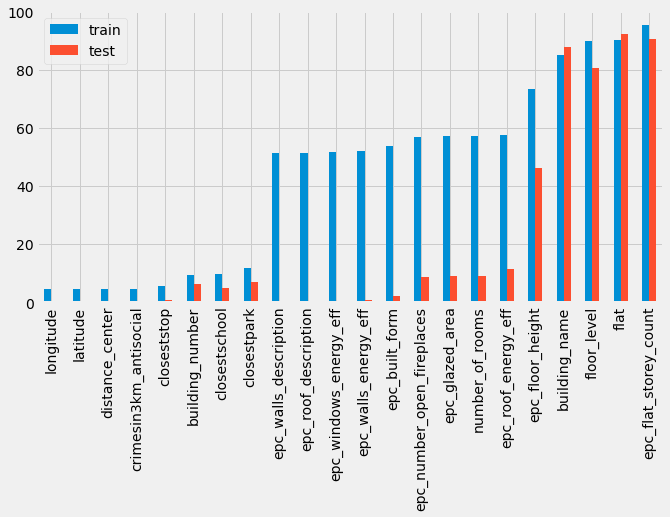

In [ ]:
nans_train = (df.isna().sum()/df.shape[0]).sort_values() *100
nans_test = (df_test.isna().sum()/df_test.shape[0]).sort_values() *100

nans = pd.concat([nans_train, nans_test], axis=1)
nans.columns = ['train', 'test']
# display(nans, 
#         (nans.train - nans.test).sort_values() )
fig, ax = plt.subplots(figsize=(10,5))
nans[(nans.train > 0)&(nans.test > 0)].plot(kind='bar', ax=ax)

Существуют признаки, в которых нет пропусков в тестовом наборе,в то время как в обучающей выборки есть множество наблюдений с пропусками в соответствующих признаках.

**!!! Разное количество пропусков в таких призанаках описание окон, крыши итд**. Можно попробовать:
* Заполнить пропуски средним по дому (квартиры в одном доме)
* Полностью удалить наблюдения с пропусках в данных признаках
* Удалить наблюдения в выборке для валидации, но оставить в обучающей


In [ ]:
nans['diff'] = nans.train - nans.test
nans[(nans.train > 0)&(nans.test > 0)].sort_values('diff')

train       test       diff
building_name               85.0076  88.041521  -3.033921
flat                        90.4102  92.303075  -1.892875
building_number              9.4356   6.365851   3.069749
longitude                    4.5882   0.007061   4.581139
latitude                     4.5882   0.007061   4.581139
distance_center              4.5882   0.007061   4.581139
crimesin3km_antisocial       4.6138   0.010592   4.603208
closestschool                9.6884   5.059492   4.628908
closeststop                  5.6744   0.956820   4.717580
closestpark                 11.7462   6.916640   4.829560
epc_flat_storey_count       95.6534  90.798997   4.854403
floor_level                 90.0182  80.598807   9.419393
epc_floor_height            73.5004  46.195671  27.304729
epc_roof_energy_eff         57.7656  11.577163  46.188437
epc_glazed_area             57.1432   8.996222  48.146978
number_of_rooms             57.1432   8.996222  48.146978
epc_number_open_fireplaces  56.9944   8.731420  48.262980
epc_walls_energy_eff        52.1944   0.914451  51.279949
epc_roof_description        51.5674   0.067083  51.500317
epc_walls_description       51.5506   0.010592  51.540008
epc_windows_energy_eff      51.9394   0.363662  51.575738
epc_built_form              53.9488   2.231402  51.717398

<AxesSubplot:>

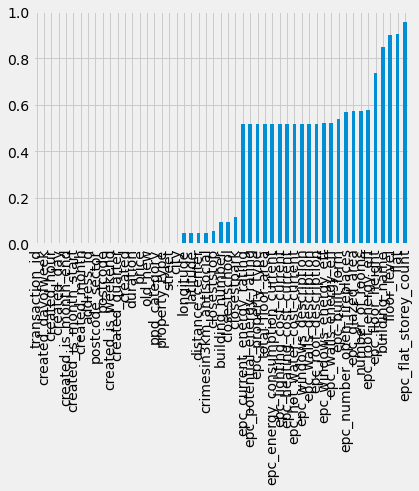

In [ ]:
(df.isna().sum()/ df.shape[0]).sort_values().plot(kind='bar')

In [ ]:
temp = df.isna().sum()/ df.shape[0]
temp[temp > 0].sort_values()

street                            0.000002
city                              0.000014
latitude                          0.045882
longitude                         0.045882
distance_center                   0.045882
crimesin3km_antisocial            0.046138
closeststop                       0.056744
building_number                   0.094356
closestschool                     0.096884
closestpark                       0.117462
epc_potential_energy_rating       0.515476
epc_property_type                 0.515476
epc_energy_consumption_current    0.515476
epc_lighting_cost_current         0.515476
epc_hot_water_cost_current        0.515476
total_floor_area                  0.515476
epc_current_energy_rating         0.515476
epc_heating_cost_current          0.515476
epc_windows_description           0.515478
epc_walls_description             0.515506
epc_roof_description              0.515674
epc_windows_energy_eff            0.519394
epc_walls_energy_eff              0.521944
epc_built_f

### Время
Понятно, что год создания заявки не будет учитываться, т.к. в тесте у нас только один определенный год, а одучаемся мы на данных из будущего. 

Посмотрим на такие временные признаки как месяц, квартал, чило, день недели и пр

In [ ]:
df.created_month.value_counts(), df_test.created_month.value_counts()

(8     49008
 6     48498
 7     44519
 3     43746
 10    43404
 9     42452
 11    42201
 5     40929
 12    36848
 4     36815
 2     36449
 1     35131
 Name: created_month, dtype: int64,
 1    19373
 2     8950
 Name: created_month, dtype: int64)

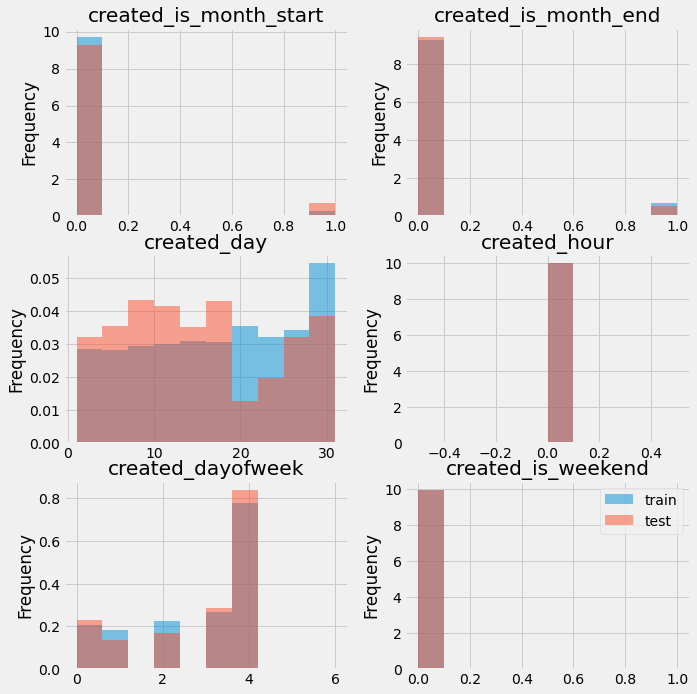

In [ ]:
# В тесте слишком мало данных и они представлены всего за 2 месяца,
# поэтому месяц и квартал делают нашу выборку для обучения нерепрезентативной относительно теста
# удалим их и посмотрим на другие врменные признаки

to_drop = ['created_month', 'created_quarter']
features = [f for f in df.columns if 'created' in f and f not in to_drop + ['created']]

fig, axes = plt.subplots(3, 2, figsize=(2*5, 2*5.5))
for f, ax in zip(features, axes.ravel()):
    df[f].astype('int').plot(kind='hist', density=1, alpha=0.5, 
                             label='train', ax=ax)
    df_test[f].astype('int').plot(kind='hist', density=1, alpha=0.5, 
                                  label='test', ax=ax)
    ax.set_title(f)
plt.legend();


* Большой разницы в распределении признаков трейн\тест не наблюдается
* есть небольшая разница в респределениях для дня создания,но скорее всего это объясняется тем, что в тесте всего 2 месяц и не факт, что полных месяца
* час создания - отсутсвует, удалить
* в двух выборках практически отсутсвуют записи, созданные в выходные дни

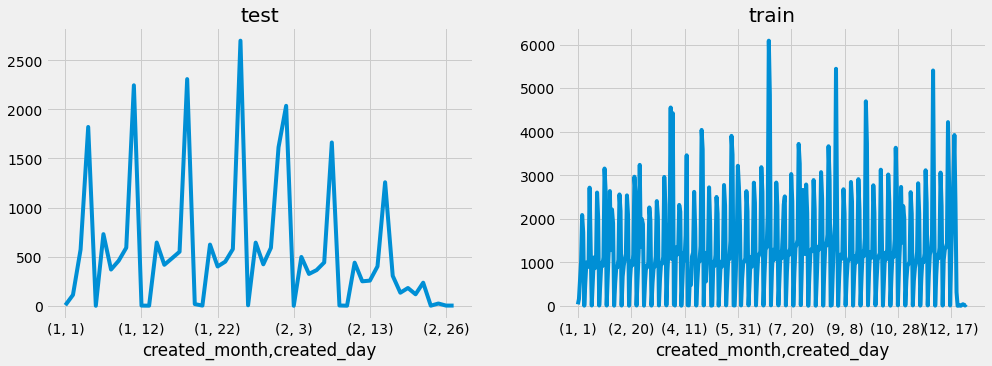

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
df_test.groupby(['created_month', 'created_day']).created.count().plot(ax=axes[0], title='test');
df.groupby(['created_month', 'created_day']).created.count().plot(ax=axes[1], title='train');

* минимумы соответсвуют выходным дням, а период равен неделе
* дествительно, в тесте присутвует уменьшение количества наблюдений со временем. Возможно это определяется методикой сборки данных

In [ ]:
to_drop = ['created_month', 'created_quarter', 'created_hour']
df.drop(to_drop, axis=1, inplace=True)
df_test.drop(to_drop, axis=1, inplace=True)

### Проверка зависимости признаков от времени
Т.к. выборки соответвуют разным вренным промежуткам, надо убедиться, что текущие признаки не меняются со временем. Объеденим выборки и попробуем обучить модель разделять их

In [ ]:
df['test'] = 0
df_test['test'] = 1
data = pd.concat([df.iloc[:100_000], df_test], axis=0)

# data[features_str] = data[features_str].apply(lambda x: np.where(x.isna(), 'None', x))
data[features_cat] = data[features_cat].apply(lambda x: np.where(x.isna(), 'nan', x))

to_drop = ['transaction_id', 'created', 'price', 'test'] + features_str + features_address

train, test = train_test_split(data, stratify=data.test)

model = CatBoostClassifier(iterations=30,
                           depth=6,
                           learning_rate=0.1,
                           loss_function='Logloss',
                           verbose=False)

model.fit(train.drop(to_drop, axis=1), train.test, cat_features=features_cat,
        #    text_features=features_str
           )
preds = model.predict(Pool(test.drop(to_drop, axis=1), test.test, 
                                 cat_features=features_cat))

print(test.test.value_counts())
print(confusion_matrix(test.test, preds))
print(f'f1 = {f1_score(test.test, preds, average="macro")}')
fi = pd.Series(model.feature_importances_, index=data.drop(to_drop, axis=1).columns).sort_values()
fi = fi[fi > 0.5]
fi

0    25000
1     7081
Name: test, dtype: int64
[[24084   916]
 [ 3064  4017]]
f1 = 0.7961992936598387


created_is_month_start             1.582693
epc_energy_consumption_current     3.116827
ppd_category                       6.169253
epc_hot_water_cost_current         8.280639
created_dayofweek                 15.130608
total_floor_area                  17.125492
epc_lighting_cost_current         18.718629
created_day                       28.216757
dtype: float64

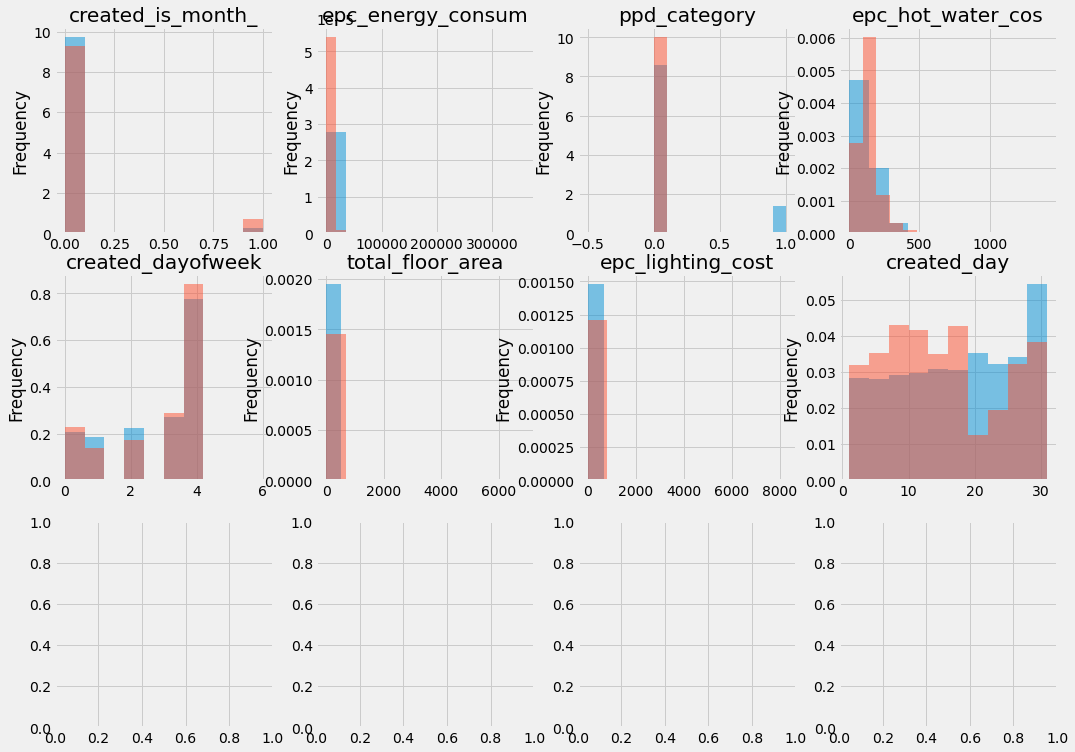

In [ ]:
fig, axes = plt.subplots(3,4, figsize=(4*4, 3*4))
for f, ax in zip(fi.index, axes.ravel()):
    temp, temp_test = df[f].copy(), df_test[f].copy()
    if temp.dtype.name == 'category':
        temp = temp.cat.codes
        temp_test = temp_test.cat.codes
    temp.plot(kind='hist', density=1, alpha=0.5, label='train', ax=ax)
    temp_test.plot(kind='hist', density=1, alpha=0.5, label='test', ax=ax)
    ax.set_title(f[:17])

Эти признаки являются потенциальными на удаление, т.к. используя тольки их можно разделить данные на трейн\тест, а значит обучающая выборка по этим признакам не соответвует тому, что будем предсказывать в итоге

### Адрес
Посмотрим, встречается ли одна и та же больше 1 раза.

In [ ]:
df.address_id.nunique(), df.shape[0]

(475051, 500000)

Есть такой признак как address_id = уникальный номер адреса. Не совсем понятно уникален ли этот номер для отдельной квартиры или для дома целиком. Посмотрим встречаются ли в рамках одного address_id несколько разных номеров квартир flat

In [ ]:
ids = df.address_id.value_counts()
ids = ids[ids > 1].index

features = ['flat', 'postcode', 'city', 'street', 
            'building_name', 'building_number']

res = df[df.address_id.isin(ids)].groupby('address_id')[features]\
                           .apply(lambda x: x.nunique())
res[res > 1].sum()

flat               27400.0
postcode               0.0
city                   0.0
street                 0.0
building_name          0.0
building_number        0.0
dtype: float64

Итак, количество уникальных номеров квартир на один adress_id может быть больше 1. При этом остальные характеристики здания (город и полный адрес) совпадают. Значит address_id соответствует уникальным зданиям, но не квартирам в них.

Значит можно группировать по adress_id, flat - уникальная комбинация для каждой квартиры и посмотреть есть ли несколько наблюдений для одной и тойже квартиры

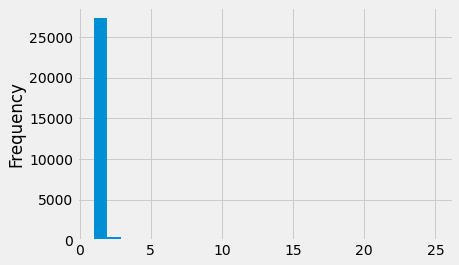

In [ ]:
temp = df[df.address_id.isin(ids)]
unique_flat = temp.groupby(['address_id', 'flat'], sort=False).transaction_id.count()
unique_flat.plot(kind='hist', bins=25)

unique_flat = unique_flat[unique_flat > 1].index

Большинство квартир не имеет повторов (по 1 записи на квартиру), но есть наблюдения, для которых есть несколько наблюдений.

Проверим, что квартиры имеют одинаковые признаки и отличаются только возможно ценой price, включены ли в цену доп издержки ppd_category, новостройка/вторичка (new/old) и датой публикации

In [ ]:
to_drop = ['transaction_id', 'price', 'ppd_category', 'old_new'] + \
          [f for f  in df.columns if 'created' in f]
non_unique_flat = []

for adr,flat in unique_flat:
    temp = df[(df.address_id == adr)&(df.flat == flat)].drop(to_drop, axis=1)\
                                                       .drop_duplicates()
    if temp.shape[0] != 1: non_unique_flat.append((adr, flat))

len(non_unique_flat), unique_flat.shape

(44, (376,))

In [ ]:
test = df_test['address_id'].astype('str') + df_test['flat'].astype('str')
train = df['address_id'].astype('str') + df['flat'].astype('str')
(test.drop_duplicates().isin(train.drop_duplicates())).sum(), test.drop_duplicates().shape[0], test.shape[0]

(566, 28246, 28323)

Часть квартир почему-то имеют разные характеристики со своими дубликатами. Посмотрим на эти наблюдения и только на те признаки, в которых есть отличия

In [ ]:
j = 0
for i, gr in df.set_index(['address_id', 'flat']).loc[non_unique_flat].groupby(['address_id', 'flat']):
    j = j+1
    temp = gr.drop(to_drop, axis=1).nunique()
    f_diff = temp[temp > 1].index
    display(gr[['created', 'price'] + f_diff.to_list()])
    if j > 10: break

created  price duration property_type
address_id flat                                         
88998450   1    2017-01-20  84000        L             F
           1    2018-03-01   4000        F             O

created   price duration property_type
address_id flat                                          
89309350   1    2017-02-28  338933        L             F
           1    2017-02-28  150000        F             O
           1    2017-02-28  150000        F             O

created  price duration property_type
address_id flat                                         
89434041   A    2017-12-01   9450        F             O
           A    2018-01-26  54000        L             F

created   price property_type
address_id flat                                 
91876583   8    2018-01-12  300000             O
           8    2018-01-12  300000             F

created   price duration
address_id flat                            
92261342   1    2018-02-15  410000        L
           1    2018-08-01  350000        F

created   price property_type
address_id flat                                 
92336807   1    2017-07-07   30000             O
           1    2017-03-06  183000             F

created   price property_type
address_id flat                                 
92437226   2    2018-10-19  445000             F
           2    2018-05-04  900000             O

created   price property_type
address_id flat                                 
93336084   28   2017-01-20  100000             F
           28   2017-01-20  100000             O

created   price duration property_type
address_id flat                                          
93434327   8    2018-07-06  185000        L             F
           8    2017-04-11   56250        F             O

created   price property_type
address_id flat                                 
93746717   59   2017-01-12  230000             F
           59   2017-01-12  230000             O

created   price property_type
address_id flat                                 
93900929   1303 2018-05-04  200000             F
           1303 2018-05-04  200000             O

* Признак duration можно интерпретировать продажа или долгосрочная аренда, т.е. изменение этого признака у одного объекта может быть. 
* property_type характеризует тип недвижимости - дом, квартира итд. Изменение этого признака, особенно на категорию О (другое) может быть объяснено те, что люди по разному характеризуют свое имущество

**!!! Попробовать:** 
* при повторах заменить категорию О на другую, если она есть в других наблюдениях + если создадутся дубликаты, удалить их
* создать признак - предыдущая цена, но цена для продажи и аренды различные категории, так что 2 признака - предыдущая ценая для сдачи и для аренды. Так же можно добавить время с предыдущего объявления

In [ ]:
df['flat'] = df['flat'].astype('string').fillna('None')
df['address'] = df['address_id'].astype('string') + df.flat
df.address.nunique()

495254

In [ ]:
df[features_address].nunique()

street             139104
city                  349
building_number      4168
flat                 1671
building_name       37204
postcode_sector      8205
postcode           343799
dtype: int64

In [ ]:
df[['city', 'street']].drop_duplicates().shape[0]

256910

In [ ]:
features = df.select_dtypes(exclude=['object', 'category', 'datetime64[ns]', 'string']).columns.tolist()

In [ ]:
temp = df[features + ['postcode_sector']]
temp[features] = temp[features].astype('float')
temp.groupby('postcode_sector').mean()

price  number_of_rooms  total_floor_area  \
postcode_sector                                                     
AL1 1            524276.641304         4.459459         90.010417   
AL1 2            475970.804878         4.344828         79.757292   
AL1 3            494661.924051         2.812500         62.344460   
AL1 4            758478.525000         5.200000        108.350291   
AL1 5            466519.671053         3.972222         71.903846   
...                        ...              ...               ...   
YO8 4            156968.550000         4.290323         98.049107   
YO8 5            196981.132653         4.729730         78.759615   
YO8 6            223087.500000         5.470588        115.003472   
YO8 8            183435.516129         4.535714         87.845139   
YO8 9            214797.460432         5.130435         92.248326   

                 epc_energy_consumption_current  epc_lighting_cost_current  \
postcode_sector                                                              
AL1 1                               1230.333333                  76.614583   
AL1 2                                283.100000                  71.600000   
AL1 3                                217.295455                  58.363636   
AL1 4                                304.069767                  92.677326   
AL1 5                                300.641026                  67.970353   
...                                         ...                        ...   
YO8 4                               2510.685714                  83.581250   
YO8 5                                292.794872                  76.435897   
YO8 6                                292.555556                  98.303819   
YO8 8                                214.866667                  75.381944   
YO8 9                                237.250000                  79.886161   

                 epc_heating_cost_current  epc_hot_water_cost_current  \
postcode_sector                                                         
AL1 1                          668.282051                  127.423077   
AL1 2                          626.633333                  126.300000   
AL1 3                          311.068182                  159.409091   
AL1 4                          896.290698                  132.927326   
AL1 5                          628.535256                  128.290064   
...                                   ...                         ...   
YO8 4                          786.242857                  143.767857   
YO8 5                          637.769231                  143.512821   
YO8 6                         1149.902778                  218.355903   
YO8 8                          548.472222                  121.655556   
YO8 9                          648.787946                  131.930804   

                 epc_flat_storey_count  epc_number_open_fireplaces  \
postcode_sector                                                      
AL1 1                         3.428571                    0.243243   
AL1 2                         2.500000                    0.275862   
AL1 3                         2.833333                    0.187500   
AL1 4                         2.600000                    0.600000   
AL1 5                         2.777778                    0.250000   
...                                ...                         ...   
YO8 4                         2.000000                    0.129032   
YO8 5                              NaN                    0.135135   
YO8 6                              NaN                    0.411765   
YO8 8                         5.000000                    0.142857   
YO8 9                              NaN                    0.086957   

                 epc_floor_height  ...  crimesin3km_antisocial  closestschool  \
postcode_sector                    ...                                          
AL1 1                    2.479980  ...             1814.027397     335.328767   
AL1 2   

### lat/lon

In [ ]:
import folium
from folium.plugins import MarkerCluster

In [ ]:
# из-за ограничения памати визуализируе только 10_000 точек
lat, lon = df.latitude.astype('float').mean(), df.longitude.astype('float').mean()

map = folium.Map(location=[lat, lon], zoom_start=5)
df[['latitude', 'longitude']].dropna().iloc[:10_000].apply(lambda x: 
                                    folium.CircleMarker(location=[x.latitude, 
                                                                  x.longitude],
                                    radius = 5, 
                                    # popup=str(elevation)+" m", 
                                    fill_color="gray", 
                                    color=None,#"gray",
                                     fill_opacity = 0.1).add_to(map),
                                    axis=1
                                    );
                                    
map

In [ ]:
del map
gc.collect()

In [ ]:
df.isna().sum().sort_values()

transaction_id                         0
created_is_weekend                     0
created_dayofweek                      0
created_hour                           0
created_day                            0
created_is_month_end                   0
created_is_month_start                 0
created_month                          0
address_id                             0
postcode_sector                        0
postcode                               0
created_quarter                        0
address                                0
ppd_category                           0
created                                0
flat                                   0
duration                               0
price                                  0
old_new                                0
property_type                          0
street                                 1
city                                   7
longitude                          22941
latitude                           22941
distance_center 

### Таргет - цена

<AxesSubplot:>

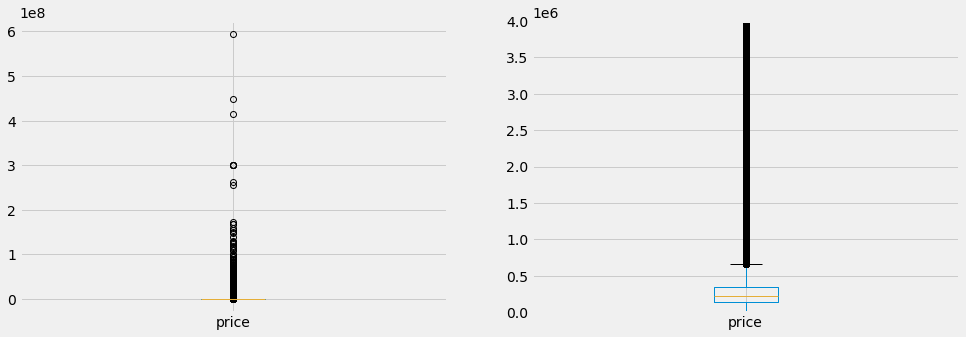

In [ ]:
fix, axes = plt.subplots(1,2, figsize=(15,5))
df.price.plot(kind='box', ax=axes[0])
df.price.plot(kind='box', ylim=(0, 0.4e7), ax=axes[1])

Cравним объясняется ли высокая цена этими признакми площадь и количество конат и посмотрим влияние признака расстояние до центра

In [ ]:
tr = 4e6
print(df[df.price >= tr].shape[0])

features = ['total_floor_area', 'number_of_rooms', 'distance_center']
temp = pd.concat((df[df.price < tr][features].astype('float').mean(), 
           df[df.price>=tr][features].astype('float').mean()), axis=1)
temp.columns = ['main price', 'extra hight price']
temp

1686


main price  extra hight price
total_floor_area   89.890056         245.276322
number_of_rooms     4.564768           7.285124
distance_center     6.206578           3.349310

### Анализ категориальных признаков

In [ ]:
np.random.seed(2021)
idx = np.random.choice(np.arange(0, df.shape[0]),
                                 size=50_000, replace=False)
data = pd.concat((df.iloc[idx], df_test), axis=0)
# data.shape[0]
# sns.pairplot(temp[features_num[:10]])

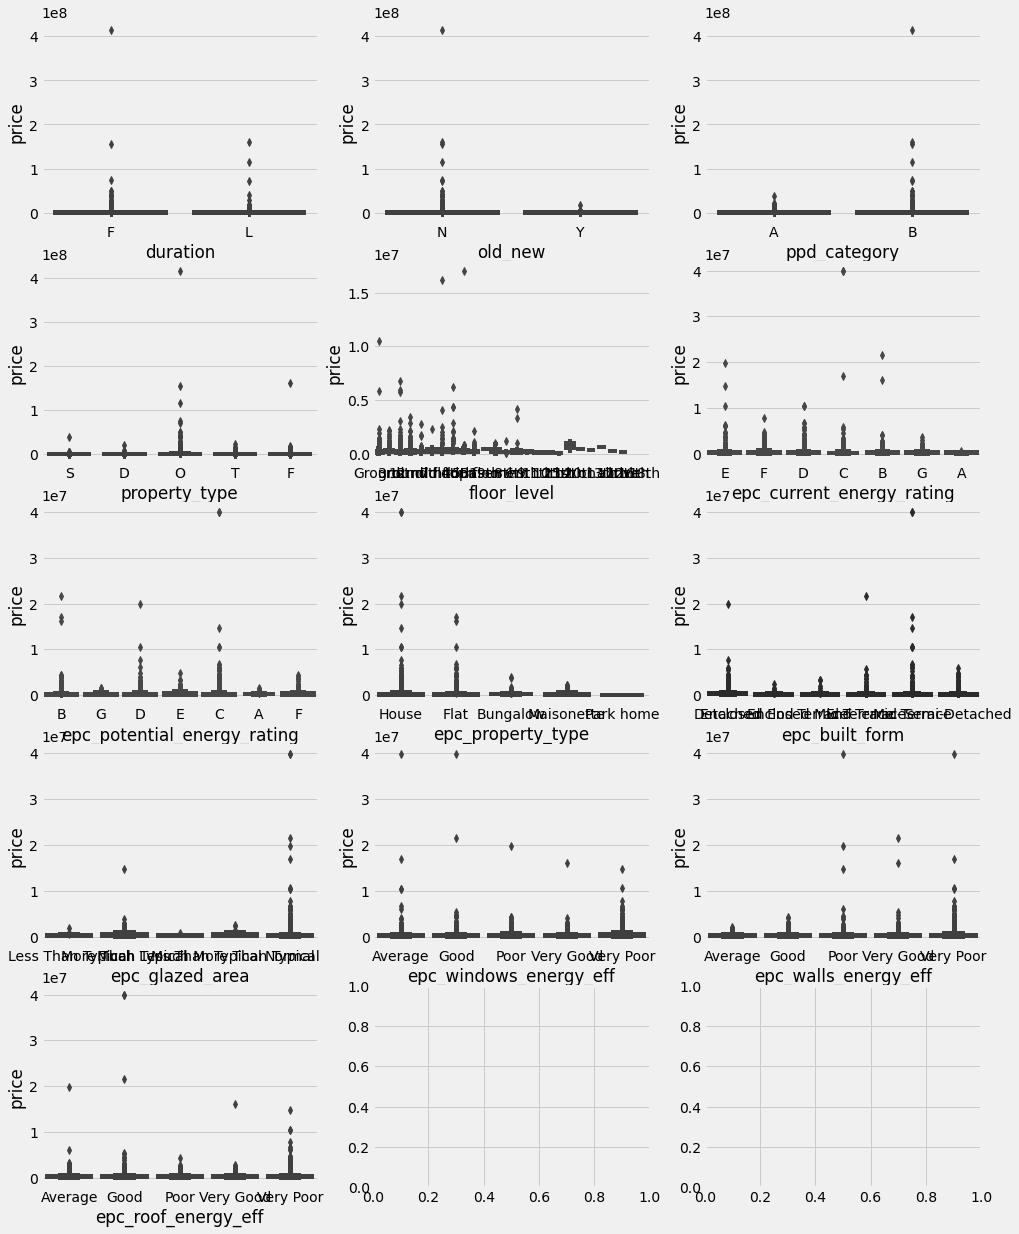

In [ ]:
fig, axes = plt.subplots(5,3, figsize=(3*5, 5*4))
for f, ax in zip(features_cat, axes.ravel()):
    sns.boxplot(data=data, x=f, y='price', ax=ax)

In [ ]:
idx = np.random.choice(np.arange(0, df.shape[0]),
                                 size=50_000, replace=False)
data = df.iloc[idx]
res = []
for f in features_cat:
    res.append({'f': f,
                'p': ss.mstats.kruskalwallis(*[gr.values 
                                        for i,gr in df.groupby(f, sort=False).price]).pvalue})

res = pd.DataFrame(res)
res[res.p >= 0.05]

Empty DataFrame
Columns: [f, p]
Index: []

Для всех признаков p-val меньше 0.05, отвергаем нулевую ипотезу, и есть ходя по олной паре отличающихся категорий. 

**!!! Разобраться** чувствителен ли этот тест к количеству наблюдений? 

In [ ]:
def cramers_corrected_stat(df, f1, f2,):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(df[f1], df[f2])
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    if r == 2 and k == 2:
         print('2*2 contingency table. Try Fisher')
         return None
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)

    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [ ]:
res2 = []
for f1, f2 in combinations(features_cat, 2):
    res2.append({'f1': f1, 'f2': f2,
    'cramer': cramers_corrected_stat(df, f1, f2)
    })
    
res2 = pd.DataFrame(res2).sort_values('cramer')

2*2 contingency table. Try Fisher
2*2 contingency table. Try Fisher
2*2 contingency table. Try Fisher


In [ ]:
res2[res2.cramer > 0.1]


f1                           f2    cramer
65            epc_property_type       epc_windows_energy_eff  0.100620
66            epc_property_type         epc_walls_energy_eff  0.102705
39                property_type       epc_windows_energy_eff  0.104340
5                      duration  epc_potential_energy_rating  0.110325
45                  floor_level               epc_built_form  0.111882
10                     duration         epc_walls_energy_eff  0.114871
33                property_type                  floor_level  0.122111
51    epc_current_energy_rating            epc_property_type  0.144868
22                      old_new          epc_roof_energy_eff  0.145666
34                property_type    epc_current_energy_rating  0.147643
44                  floor_level            epc_property_type  0.150799
43                  floor_level  epc_potential_energy_rating  0.153883
70               epc_built_form         epc_walls_energy_eff  0.154336
9                      duration       epc_windows_energy_eff  0.155270
40                property_type         epc_walls_energy_eff  0.163348
16                      old_new  epc_potential_energy_rating  0.170999
13                      old_new                property_type  0.176093
63            epc_property_type               epc_built_form  0.185208
62  epc_potential_energy_rating          epc_roof_energy_eff  0.190589
42                  floor_level    epc_current_energy_rating  0.195779
7                      duration               epc_built_form  0.219347
3                      duration                  floor_level  0.227735
60  epc_potential_energy_rating       epc_windows_energy_eff  0.229859
15                      old_new    epc_current_energy_rating  0.231342
76       epc_windows_energy_eff          epc_roof_energy_eff  0.242466
61  epc_potential_energy_rating         epc_walls_energy_eff  0.245151
4                      duration    epc_current_energy_rating  0.250611
21                      old_new         epc_walls_energy_eff  0.260993
49                  floor_level          epc_roof_energy_eff  0.273291
56    epc_current_energy_rating          epc_roof_energy_eff  0.293729
20                      old_new       epc_windows_energy_eff  0.295013
77         epc_walls_energy_eff          epc_roof_energy_eff  0.303396
50    epc_current_energy_rating  epc_potential_energy_rating  0.308517
14                      old_new                  floor_level  0.347690
54    epc_current_energy_rating       epc_windows_energy_eff  0.372520
48                  floor_level         epc_walls_energy_eff  0.402500
75       epc_windows_energy_eff         epc_walls_energy_eff  0.411046
55    epc_current_energy_rating         epc_walls_energy_eff  0.411210
47                  floor_level       epc_windows_energy_eff  0.413762
36                property_type            epc_property_type  0.498858
23                 ppd_category                property_type  0.622387
37                property_type               epc_built_form  0.649198
2                      duration                property_type  0.807251
6                      duration            epc_property_type  0.807629

In [ ]:
pd.crosstab(df['epc_property_type'],df['property_type'])

property_type          D      F     O      S      T
epc_property_type                                  
Bungalow           12455     21   556   6267    847
Flat                 161  40540  1423    400    965
House              38276    621  3500  56693  74812
Maisonette            42   3983   301    113    283
Park home              2      0     1      0      0

Есть категориальные признаки, которые сильно корелируют - например тип здания иеет две вариации

### Анализ численных признаков

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df[features_num].corr(), cmap=sns.diverging_palette(220, 20, as_cmap=True), 
            annot=True, fmt='.1f');

KeyError: "['created_month', 'created_quarter', 'created_hour'] not in index"

<Figure size 1080x1080 with 0 Axes>

На прямую признаки не коррелируют с таргетом. Это и понятно, что цена зависит не просто он растояния до центра, но и относительного какого города учитывается центр итп

### Анализ строковых признаков

In [ ]:
display(*[df[features_str].dropna().iloc[i] for i in range(0,10)])

epc_windows_description                           Fully double glazed
epc_walls_description      Cavity wall, as built, insulated (assumed)
epc_roof_description                         (another dwelling above)
Name: 735185, dtype: string

epc_windows_description                             Mostly double glazing
epc_walls_description      Solid brick, as built, no insulation (assumed)
epc_roof_description                      Pitched, 100 mm loft insulation
Name: 593245, dtype: string

epc_windows_description                    High performance glazing
epc_walls_description      Average thermal transmittance 0.24 W/m²K
epc_roof_description       Average thermal transmittance 0.10 W/m²K
Name: 324559, dtype: string

epc_windows_description    Window
epc_walls_description        Wall
epc_roof_description         Roof
Name: 1890, dtype: string

epc_windows_description                Fully double glazed
epc_walls_description           Cavity wall, filled cavity
epc_roof_description       Pitched, 250 mm loft insulation
Name: 463270, dtype: string

epc_windows_description                               Fully double glazed
epc_walls_description      Cavity wall, as built, no insulation (assumed)
epc_roof_description                             (another dwelling above)
Name: 164938, dtype: string

epc_windows_description                               Fully double glazed
epc_walls_description      Cavity wall, as built, no insulation (assumed)
epc_roof_description                   Flat, limited insulation (assumed)
Name: 291543, dtype: string

epc_windows_description                                     Single glazed
epc_walls_description      Cavity wall, as built, no insulation (assumed)
epc_roof_description                      Pitched, 100 mm loft insulation
Name: 77638, dtype: string

epc_windows_description                 Fully double glazed
epc_walls_description            Cavity wall, filled cavity
epc_roof_description       Pitched, no insulation (assumed)
Name: 213113, dtype: string

epc_windows_description                           Fully double glazed
epc_walls_description      Cavity wall, as built, insulated (assumed)
epc_roof_description                  Pitched, 250 mm loft insulation
Name: 791638, dtype: string

Посмотрим отдельно на каждый признак. Для начала, не силишком высокое значение кардинальности позволяет нам использовать признак как категориальный. Описание окон как соответсвует этому типу

In [ ]:
f = 'epc_windows_description'
print(df[f].nunique())
df[f] = df[f].astype('category')
features_cat.append(f)
features_str.remove(f)

40


Если кардинальность слишко большая, посмотрим поближе на опсание, которое содержится в наблюдениях. Видно, что используются разные, но стандартные фразы. + дополнительно содержится числования информация о теплопроводности. Вытащим эти числа в отдельный признак и разобъем текст на стандартные фразы

In [ ]:
f = 'epc_walls_description'
print(df[f].nunique())
df[f].iloc[np.random.randint(0,df.shape[0], 15)].to_list()

633


['Cavity wall, as built, no insulation (assumed)',
 <NA>,
 'Solid brick, as built, no insulation (assumed)',
 <NA>,
 'Average thermal transmittance 0.34 W/m?K',
 'Solid brick, as built, no insulation (assumed)',
 <NA>,
 'Cavity wall, as built, insulated (assumed)',
 'Average thermal transmittance 0.29 W/m²K',
 'Cavity wall, filled cavity',
 <NA>,
 <NA>,
 'Solid brick, as built, no insulation (assumed)',
 'Cavity wall, as built, no insulation (assumed)',
 <NA>]

In [ ]:
tmp = '\|Trawsyriannedd thermol cyfartalog =*\s*(\d.*\d*) W/m.*K'
print(f'''rel. # of samples with cyfartalog: \
{df[f].dropna().str.extract(tmp).notna().sum()/df.shape[0]}''')
df['wall_cyfartalog'] = df[f].str.extract(tmp)
df[f] = df[f].str.replace(tmp, '')


rel. # of samples with cyfartalog: 0    0.0
dtype: float64


In [ ]:
tmp = 'transmittance =*\s*(\d.*\d*) W/m.*K'
df['wall_transmittance'] = df[f].str.extract(tmp)
print(f'''rel. # of samples with transittance: \
{df['wall_transmittance'].dropna().shape[0]/df.shape[0]}''')
df[f] = df[f].str.replace(tmp, 'ff1')

rel. # of samples with transittance: 0.044282


In [ ]:
temp = df[f].dropna().str.replace('+', ',').str.replace('.', ',').str.replace(', ',',')\
            .str.split(',', expand=True).iloc[:,:].melt().value.value_counts()
temp.tail(50)

Cavity                                   117
filled cavity                             81
with additional insulation                54
insulated (assumed)                       48
filled cavity and external insulation     39
partial insulation (assumed)              36
filled cavity and internal insulation     31
Solid Brick                               27
with internal insulation                  19
Filled Cavity insulation                  13
insulated (as                              6
insu                                       5
Waliau ceudod                              5
with external insulation                   4
fel y'u hadeiladwyd                        4
dim inswleiddio (rhagdybiaeth)             4
Internal insulation                        4
Timber Frame                               3
insulated                                  3
with internal insulatio                    3
Park home wall                             3
Gwenithfaen neu risgraig                   2
no insulat

In [ ]:
wall_cat = temp[temp > 10].index.tolist()
wall_cat.remove('')
wall_cat.__len__()
# всего всего будет 32 новых признака ohe (разреженная матрица)

32

In [ ]:
def get_sparce_data(data_ini):
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for d in data_ini:
        for term in d:
            index = vocabulary.setdefault(term, len(vocabulary))
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))

    return scipy.sparse.csr_matrix((data, indices, indptr), dtype=int)#.toarray()

In [ ]:
temp = df[f].dropna().str.replace('+', ',').str.replace('.', ',').str.replace(', ',',')\
            .str.split(',').apply(lambda x: [f for f in x if f in wall_cat])

wall_sparse = get_sparce_data(temp)
assert (wall_sparse.toarray().sum(axis=0) > 10).all()

features_str.remove(f)

In [ ]:
f = 'epc_roof_description'
df[f].iloc[np.random.randint(0,df.shape[0], 15)].to_list()

[<NA>,
 '(another dwelling above)',
 'Pitched, 300 mm loft insulation',
 'Pitched, 150 mm loft insulation',
 'Pitched, no insulation (assumed)',
 <NA>,
 'Pitched, no insulation',
 'Roof',
 'Pitched, 150 mm loft insulation',
 <NA>,
 'Pitched, 100 mm loft insulation',
 'Pitched, 300+ mm loft insulation',
 'Pitched, no insulation (assumed)',
 <NA>,
 <NA>]

In [ ]:
tmp = '(\d+)\+*\s*mm loft '
print(f'''rel. # of samples : \
{df[f].dropna().str.extract(tmp).notna().sum()/df.shape[0]}''')
df['roof_loft'] = df[f].str.extract(tmp)
df[f] = df[f].str.replace(tmp, '')


rel. # of samples : 0    0.28099
dtype: float64


In [ ]:
tmp = 'transmittance =*\s*(\d.*\d*) W/m.*K'
print(f'''rel. # of samples: \
{df[f].dropna().str.extract(tmp).notna().sum()/df.shape[0]}''')
df['roof_transmittance'] = df[f].str.extract(tmp)
df[f] = df[f].str.replace(tmp, '')


rel. # of samples: 0    0.035346
dtype: float64


In [ ]:
temp = df[f].dropna().str.replace('+', ',').str.replace('.', ',').str.replace(', ',',')\
            .str.split(',', expand=True).iloc[:,:].melt().value.value_counts()
temp.tail(50)

154


Average thermal                                    17673
insulated (assumed)                                10807
Roof room(s)                                        6835
Flat                                                5550
limited insulation (assumed)                        5283
Roof                                                4828
no insulation                                       4442
(other premises above)                              4196
insulated at rafters                                2286
SAP05:Roof                                          1372
ceiling insulated                                   1357
insulated                                           1252
Chr(13)                                              871
insulation                                           566
no insulation(assumed)                               431
limited insulation                                   410
loft insulation                                      244
no insulation (assumed)        

In [ ]:
roof_cat = temp[temp > 10].index.tolist()
roof_cat.__len__()

36

In [ ]:
assert len(features_str) == 0

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=93dfd834-f8d5-41c6-9de5-c4f79b8a1815' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>